In [1]:
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn, optim
from torch.autograd import Variable
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

In [8]:
def generate_shift_one_dim_dataset(n, p, q, seed):
    rng = np.random.RandomState(seed)
    
    us1 = rng.binomial(n=1, p=p, size=int(n * q))
    xs1 = rng.uniform(0.0, 10.0, size=int(n * q))
    noise1 = rng.normal(0.0, 20.0, size=int(n * q))
    ys1 = xs1 * xs1 * xs1 + 1 * xs1 * xs1 * xs1 * us1 + noise1
    
    us2 = rng.binomial(n=1, p=p, size=int(n * (1 - q)))
    xs2 = rng.uniform(0.0, 1.0, size=int(n * (1 - q)))
    noise2 = rng.normal(0.0, 20.0, size=int(n * (1 - q)))
    ys2 = xs2 * xs2 * xs2 + 1 * xs2 * xs2 * xs2 * us2 + noise2
    
    xs = np.concatenate((xs1, xs2))
    ys = np.concatenate((ys1, ys2))
    return xs.reshape(-1, 1), ys.reshape(-1, 1)

In [9]:
def standardize(data):
    mu = data.mean(axis=0, keepdims=1)
    scale = data.std(axis=0, keepdims=1)
    # scale[scale < 1e-10] = 1.0
    data = (data - mu) / scale
    return data, mu, scale

In [10]:
def get_dataloaders(
    X_unstandardized, y_unstandardized, X_train, y_train, X_val, y_val, X_tests, y_tests, seed,
):
    dr_train = []
    for x in X_train:
        if (x < 1):
            dr_train.append(2/11);
        else:
            dr_train.append(2);
            
    dr_val = []
    for x in X_val:
        if (x < 1):
            dr_val.append(2/11);
        else:
            dr_val.append(2);
            
    X_train, x_train_mu, x_train_scale = standardize(X_train)
    y_train, y_train_mu, y_train_scale = standardize(y_train)
    
    X_val = (X_val - x_train_mu) / x_train_scale
    y_val = (y_val - y_train_mu) / y_train_scale
    
    dr_tests = []
    for i in range(len(y_tests)):
        dr_test = []
        for x in X_tests[i]:
            if (x < 1):
                dr_test.append(2/11);
            else:
                dr_test.append(2);
        dr_tests.append(dr_test)
        y_tests[i] = (y_tests[i] - y_train_mu) / y_train_scale
        X_tests[i] = (X_tests[i] - x_train_mu) / x_train_scale

    x_train_mu = x_train_mu.item()
    x_train_scale = x_train_scale.item()
    y_train_mu = y_train_mu.item()
    y_train_scale = y_train_scale.item()
    
    train = TensorDataset(
        torch.Tensor(X_train),
        torch.Tensor(y_train),
        torch.Tensor(dr_train),
    )
    train_loader = DataLoader(
        train, batch_size=int(X_train.shape[0] * 0.25), shuffle=True
    )

    val = TensorDataset(
        torch.Tensor(X_val),
        torch.Tensor(y_val),
        torch.Tensor(dr_val),
    )
    val_loader = DataLoader(val, batch_size=len(val), shuffle=False)

    test_loaders = []
    for i in range(len(y_tests)):
        test = TensorDataset(
            torch.Tensor(X_tests[i]),
            torch.Tensor(y_tests[i]),
            torch.Tensor(dr_tests[i]),
        )
        test_loader = DataLoader(test, batch_size=len(test), shuffle=False)
        test_loaders.append(test_loader)

    return (
        X_unstandardized,
        y_unstandardized,
        train_loader,
        val_loader,
        test_loaders,
        X_train[0].shape[0],
        x_train_mu,
        x_train_scale,
        y_train_mu,
        y_train_scale,
    )

In [11]:
def get_shift_one_dim_dataloaders(
    n_train, seed, p_train, q_train, p_tests, q_tests
):
    X_train, y_train = generate_shift_one_dim_dataset(
        n=n_train, p=p_train, q=q_train, seed=seed
    )
    
    X_val, y_val = generate_shift_one_dim_dataset(
        n=int(n_train * 0.2), p=p_train, q=q_train, seed=seed
    )
    
    X_tests = []
    y_tests = []
    X_unstandardized = []
    y_unstandardized = []
    for q_test in q_tests:
        for p_test in p_tests:
            X_test, y_test = generate_shift_one_dim_dataset(
                n=10000, p=p_test, q=q_test, seed=seed + 1
            )
            X_tests.append(X_test)
            y_tests.append(y_test)
            X_unstandardized.append(X_test)
            y_unstandardized.append(y_test)
    
    return (
        get_dataloaders(X_unstandardized, y_unstandardized, X_train, y_train, X_val, y_val, X_tests, y_tests, seed)
    )

In [12]:
p_tests = [0.5, 0.9]
q_tests = [1, 0.5, 0.1]
X_unstandardized, y_unstandardized, train_loader, val_loader, test_loaders, X_train_shape, x_train_mu, x_train_scale, y_train_mu, y_train_scale = get_shift_one_dim_dataloaders(n_train=7000, seed=42, p_train=0.5, q_train=0.5, p_tests=p_tests, q_tests=q_tests)

In [13]:
l_rate = 0.01 #appropriate learning rate? 1e-2 or 1e-3
mse_loss = nn.MSELoss(reduction = 'mean')

In [14]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()
    
    def forward(self, weights, pred, y):
        loss = (weights * (pred - y)**2).mean()
        return loss

In [15]:
class Regression(pl.LightningModule):
    def __init__(self):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(1, 1) #how many layers and what size?
        self.validation_losses = []
        self.test_losses = []
    
    def forward(self, x):
        return self.fc1(x)  # No activation function?
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=l_rate) #adam optimizer
    
    def training_step(self, batch, batch_idx):
        breakpoint()
        x, y, r = batch
        logits = self.forward(x)
        weighted_loss = WeightedMSELoss()(r, logits, y)
        logs = {'loss': weighted_loss}
        training_losses.append(weighted_loss.item())
        return {'loss': weighted_loss, 'log': logs}
    
    def validation_step(self, batch, batch_idx):
        breakpoint()
        x, y, r = batch
        logits = self.forward(x)
        weighted_loss = WeightedMSELoss()(r, logits, y)
        self.log('val_loss', weighted_loss) #why do i get error message w/o this line
        self.validation_losses.append(weighted_loss.item())
        validation_losses.append(weighted_loss.item())
        return weighted_loss

    def on_validation_epoch_end(self):
        breakpoint()
        avg_loss = sum(self.validation_losses) / len(self.validation_losses)
        tensorboard_logs = {'val_loss': avg_loss}
        self.log('avg_val_loss', avg_loss, on_epoch=True, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        breakpoint()
        x, y, r = batch
        logits = self.forward(x)
        weighted_loss = WeightedMSELoss()(r, logits, y)
        predictions.append(logits)
        self.test_losses.append(weighted_loss.item())
        return weighted_loss
    
    def on_test_epoch_end(self):
        breakpoint()
        avg_loss = sum(self.test_losses) / len(self.test_losses)
        logs = {'test_loss': avg_loss}      
        avg_losses.append(avg_loss)
        return avg_loss

In [16]:
training_losses = []
validation_losses = []
model = Regression()
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='checkpoints/')
trainer = Trainer(max_epochs = 40, callbacks=[checkpoint_callback]) #epochs
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader) #comment out dataloader functions and make loop and pass dataloaders

/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/groups/swager/mliu1785/miniconda3/envs/researc ...
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorbo

Sanity Checking: 0it [00:00, ?it/s]

/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUser

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


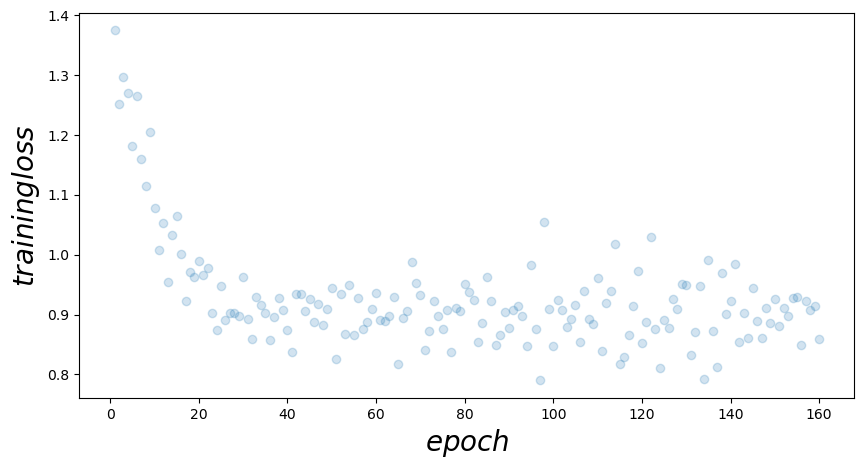

In [25]:
fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
ax2.scatter(np.arange(1, 161), training_losses, alpha=0.2)
ax2.set_xlabel(r"$epoch$", fontsize=20)
ax2.set_ylabel(r"$training loss$", fontsize=20)
# ax2.set_ylim(0, 1.5)
plt.show()

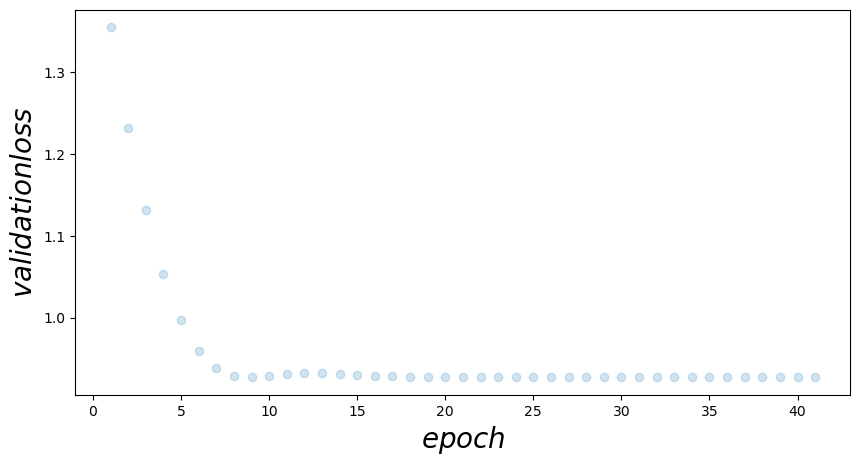

In [26]:
fig, ax2 = plt.subplots(1, 1, figsize=(10, 5))
ax2.scatter(np.arange(1, 42), validation_losses, alpha=0.2)
ax2.set_xlabel(r"$epoch$", fontsize=20)
ax2.set_ylabel(r"$validation loss$", fontsize=20)
# ax2.set_ylim(0, 1.5)
plt.show()

In [27]:
predictions = []
avg_losses = []
for i, test_loader in enumerate(test_loaders):
    trainer.test(dataloaders=test_loader, ckpt_path="best")
avg_losses

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
/home/groups/swager/mliu1785/miniconda3/envs/research/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt


Testing: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt
Loaded model weights from the checkpoint at /home/groups/swager/mliu1785/linear_ru_reg/checkpoints/epoch=7-step=32.ckpt


Testing: 0it [00:00, ?it/s]

[0.5093300342559814,
 0.5718300044536591,
 0.6756775975227356,
 0.7813718467950821,
 0.7025283098220825,
 0.6568429519732794]

In [28]:
plot_pred = []
for i in range(len(X_unstandardized)):
    test_pred = []
    for j in range(0,2):
        pred = predictions[i][j].item() * y_train_scale + y_train_mu
        test_pred.append(pred)
    plot_pred.append(test_pred)
plot_pred

[[481.9493864015941, -74.421408674352],
 [481.9493864015941, -74.421408674352],
 [625.2208216025566, 175.50242151755944],
 [625.2208216025566, 175.50242151755944],
 [457.96969062074544, 20.590762908314844],
 [457.96969062074544, 20.590762908314844]]

In [34]:
%ls -lt

total 2712
-rw-r--r--  1 mliu1785 swager   4939 Sep  7 17:49 epoch=7-step=32.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  7 16:45 epoch=39-step=160-v1.ckpt
-rw-r--r--  1 mliu1785 swager 510989 Sep  7 14:58 model_pred.png
drwxr-sr-x  4 mliu1785 swager    887 Sep  7 14:25 checkpoints/
drwxr-sr-x 23 mliu1785 swager    578 Sep  7 14:25 lightning_logs/
-rw-r--r--  1 mliu1785 swager   4939 Sep  7 13:50 epoch=36-step=148.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 21:50 epoch=37-step=152.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 21:38 epoch=23-step=96.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 20:54 epoch=29-step=120.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 20:50 epoch=46-step=188.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 17:01 epoch=99-step=400-v2.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 16:10 epoch=80-step=324.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 16:07 epoch=63-step=256.ckpt
-rw-r--r--  1 mliu1785 swager   4939 Sep  6 16:05 epoch=27-ste

In [37]:
trained_model = Regression.load_from_checkpoint('epoch=39-step=160-v1.ckpt')
trained_model.eval()
x1 = 0
x2 = 10
x1_tensor = torch.tensor([[(x1 - x_train_mu) / x_train_scale]], dtype=torch.float32)
x2_tensor = torch.tensor([[(x2 - x_train_mu) / x_train_scale]], dtype=torch.float32) 
with torch.no_grad():
    y1 = trained_model(x1_tensor)[0][0].item() * y_train_scale + y_train_mu
    y2 = trained_model(x2_tensor)[0][0].item() * y_train_scale + y_train_mu
slope = (y2 - y1) / (x2 - x1)
y_int = y1
slope, y_int

(98.07327938955027, -80.22224547963924)

[[136.57229683]] [-305.52227426]
[108.16945495] -104.47860810459733
98.07327938955027 -80.22224547963924

[[171.19925885]] [-383.20940351]
[108.16945495] -104.47860810459733
98.07327938955027 -80.22224547963924

[[106.96680962]] [-104.79407024]
[108.16945118] -104.47858593975053
98.07327938955027 -80.22224547963924

[[134.63851741]] [-131.82937967]
[108.16945118] -104.47858593975053
98.07327938955027 -80.22224547963924

[[98.77413474]] [-54.90601453]
[108.16945542] -104.47859367091553
98.07327938955027 -80.22224547963924

[[121.82066396]] [-67.48097766]
[108.16945542] -104.47859367091553
98.07327938955027 -80.22224547963924



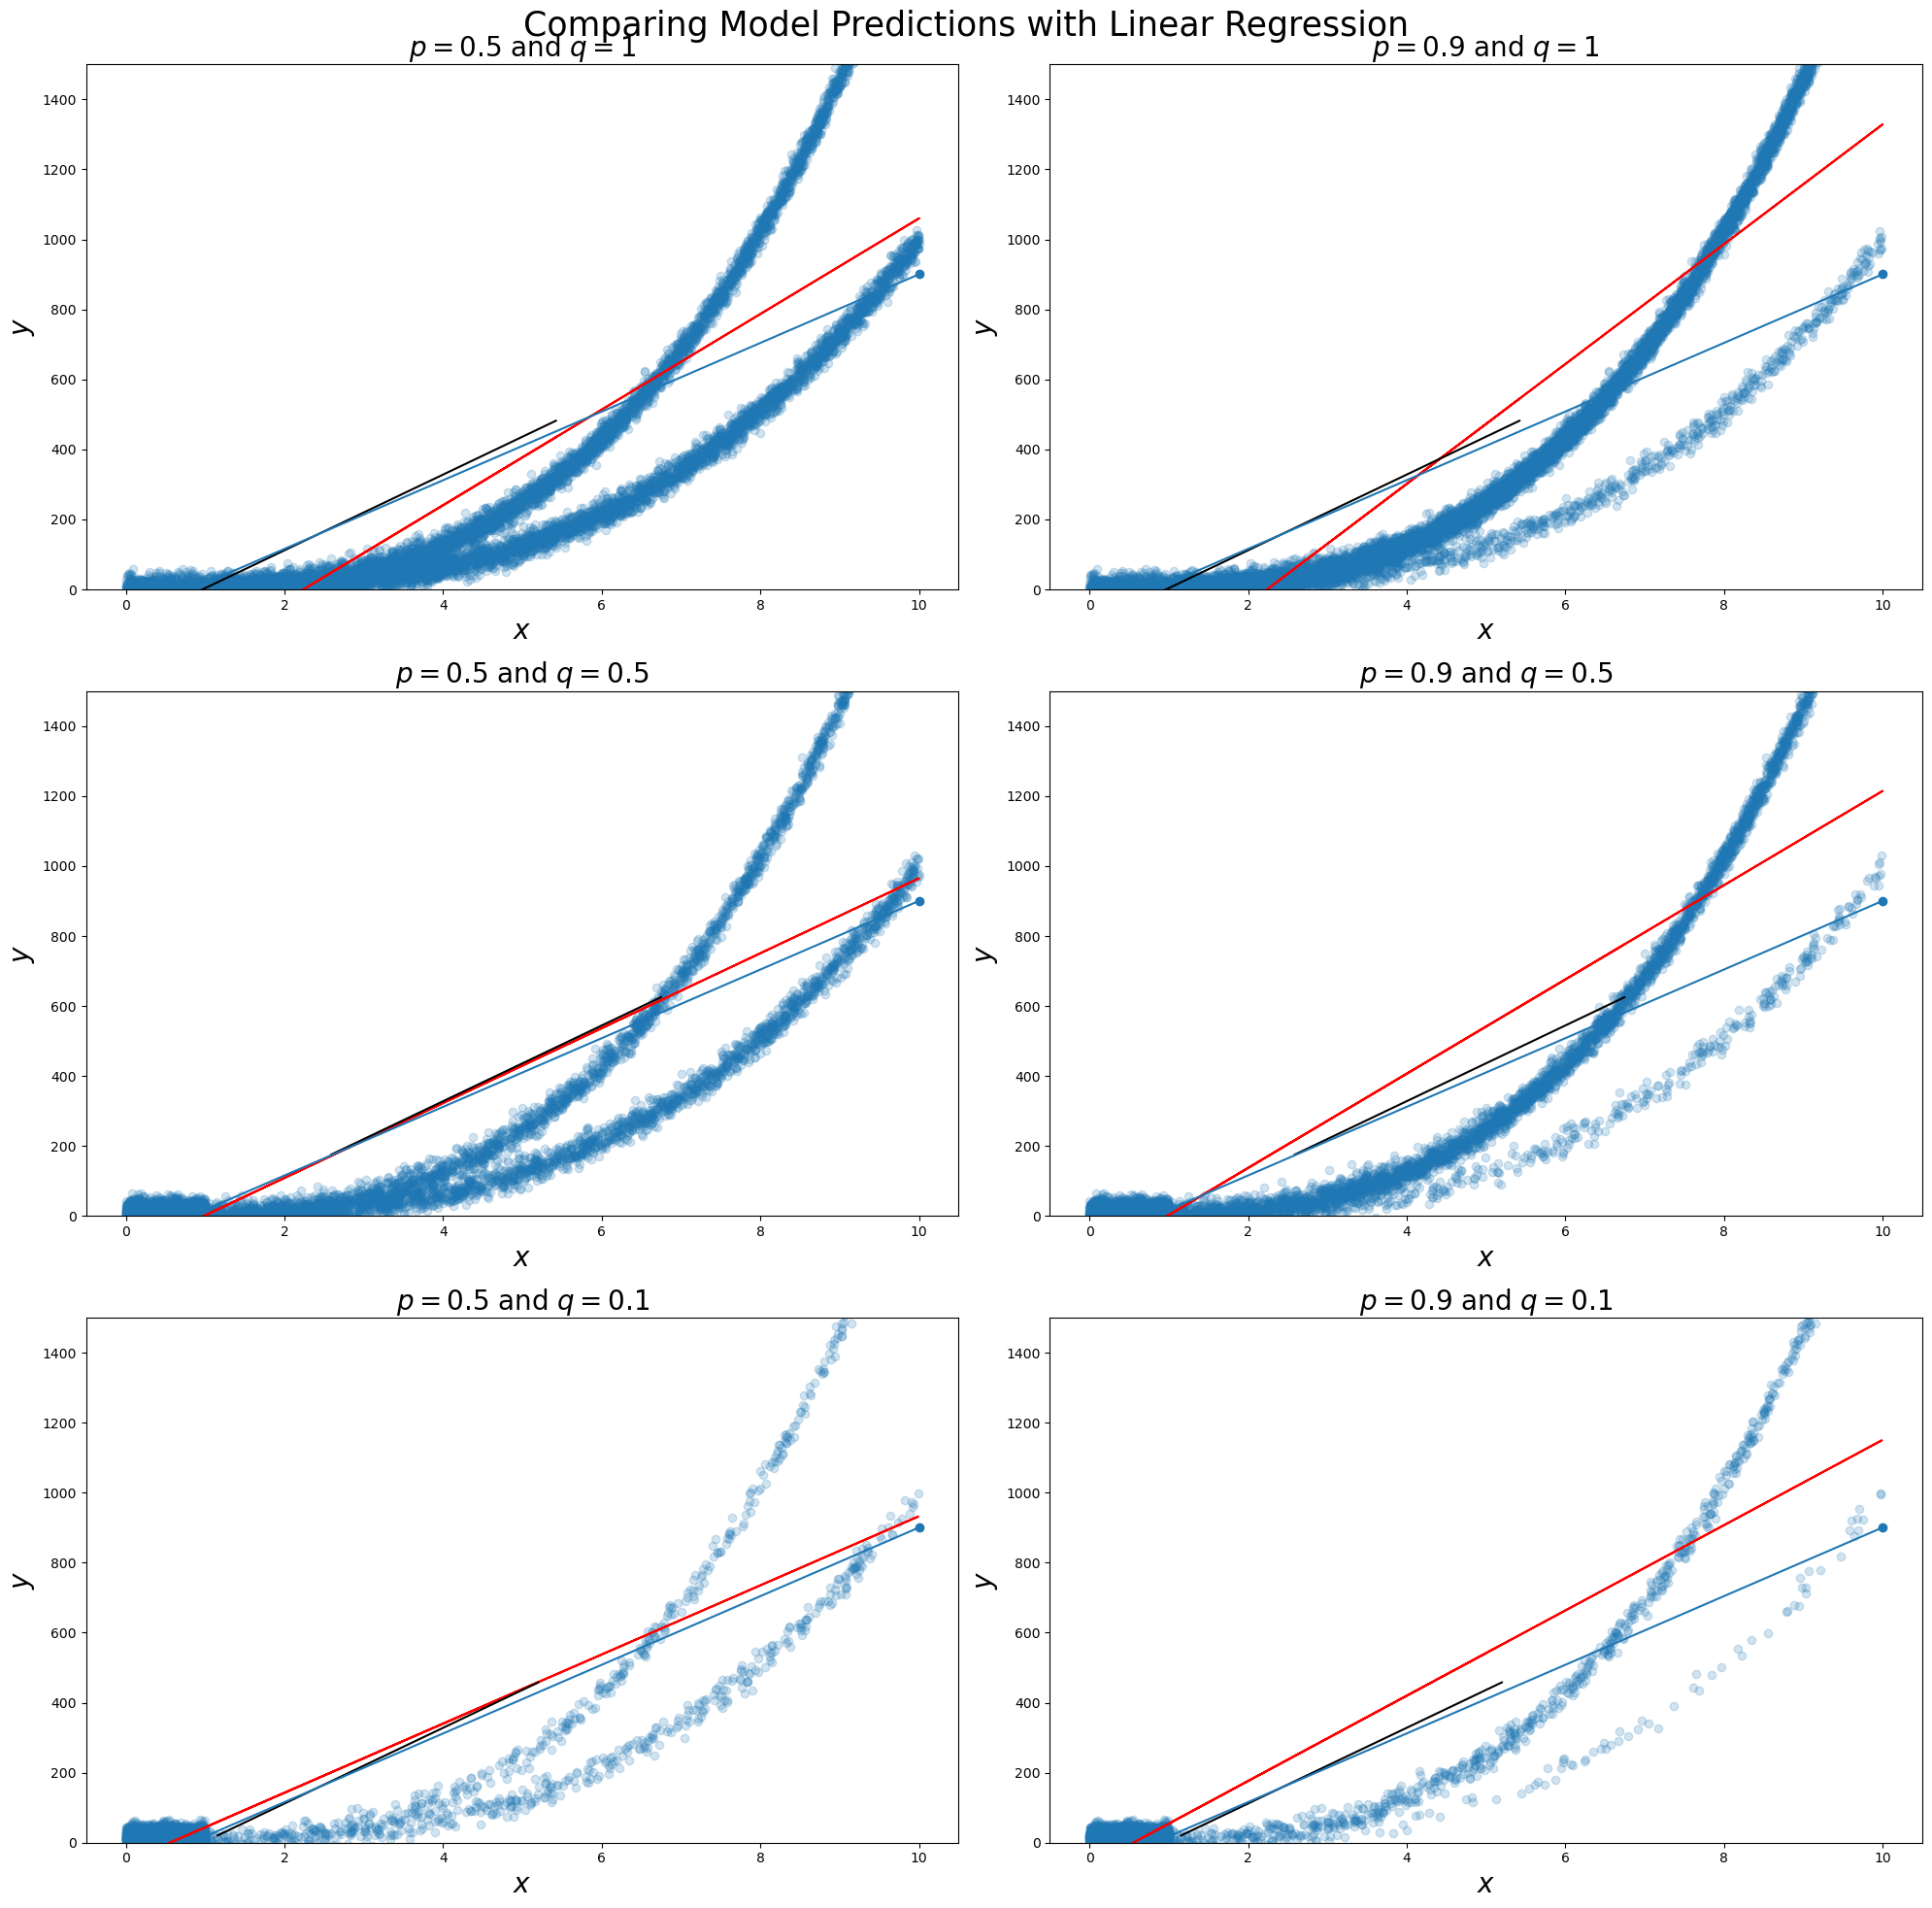

In [38]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
ax = ax.flatten();
for i in range(len(X_unstandardized)):
    ax[i].scatter(X_unstandardized[i], y_unstandardized[i], alpha=0.2)
    ax[i].set_title(r"$p={}$".format(round(p_tests[i % 2], 3)) + " and " + r"$q={}$".format(round(q_tests[int(i / 2)], 3)), fontsize=20)
    ax[i].set_xlabel(r"$x$", fontsize=20)
    ax[i].set_ylabel(r"$y$", fontsize=20)
    ax[i].set_ylim(0, 1500)
    
    lobf = LinearRegression()
    lobf.fit(X_unstandardized[i], y_unstandardized[i])
    print(lobf.coef_, lobf.intercept_)
    y_pred = lobf.predict(X_unstandardized[i])
    ax[i].plot(X_unstandardized[i], y_pred, color='red', label='Linear Regression')
    
    first_two = X_unstandardized[i][:2]
    model = LinearRegression()
    model.fit(first_two, plot_pred[i])
    print(model.coef_, model.intercept_)
    model_pred = model.predict(first_two)
    ax[i].plot(first_two, model_pred, color='black', label='Linear Regression')
    
    ax[i].plot([x1, x2], [y1, y2], marker='o', label='Points')
    print(slope, y_int)
    print()
plt.suptitle("Comparing Model Predictions with Linear Regression", fontsize=25)
plt.savefig("model_pred.png")
plt.tight_layout()